# Histopathologic Cancer Detection

This project aims at identifying metastatic tissue from a series of provided histopathologic scans of lymph node sections by applying the principles of computer vision and transfer learning. To that end, a neural network consisting of a backbone for feature extraction and a classification head is trained on the histopathologic scans. In this case, the backbone of the model is based on the pre-trained ResNet50 algorithm for a better performance. Finally, the predictive capabilities of our CNN in cancer detection are assessed.

$\color{red}{\text{[Ongoing project! :) ]}}$

## Table of Contents

* [1. Data exploration](#chapter1)
* [2. Data pre-processing](#chapter2) 
    * [2.1. Train, validation and test data](#section_2_1)
    * [2.2. Data generation](#section_2_2)
* [3. Convolutional Neural Network (CNN)](#chapter3)   
    * [3.1. ResNet50](#section_3_1)
    * [3.2. Classification head](#section_3_2)    
    * [3.3. Set-up](#section_3_3)      
* [4. Evaluation metrics](#chapter4)     
    * [4.1. Loss](#section_4_1)
    * [4.2. Accuracy](#section_4_2)    
    * [4.3. Precission](#section_4_3)     
    * [4.4. Recall](#section_4_4)   
    * [4.5. AUC](#section_4_5)    
* [5. Predictions](#chapter5)     

# 1. Data Exploration <a class="anchor" id="chapter1"></a>

Let's first load the necessary packages:

In [1]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
from sklearn.utils import shuffle
from PIL import Image
from sklearn.model_selection import train_test_split
from sklearn.utils import class_weight


from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, BatchNormalization, GlobalAveragePooling2D
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.applications import ResNet50

In this dataset, you are provided with a large number of small pathology images to classify. Files are named with an image id. The train_labels.csv file provides the ground truth for the images in the train folder. You are predicting the labels for the images in the test folder. A positive label indicates that the center 32x32px region of a patch contains at least one pixel of tumor tissue. Tumor tissue in the outer region of the patch does not influence the label. This outer region is provided to enable fully-convolutional models that do not use zero-padding, to ensure consistent behavior when applied to a whole-slide image.

The original PCam dataset contains duplicate images due to its probabilistic sampling, however, the version presented on Kaggle does not contain duplicates. We have otherwise maintained the same data and splits as the PCam benchmark.

In this case, we have a folder where all the histopathologic images are gathered, and a .csv file containing information regarding the ground truth of the scans.

In [2]:
cd = os.getcwd()
list_f = os.listdir(cd)
list_f

['train_labels.csv',
 'best_model.h5',
 '.DS_Store',
 'cancer.ipynb',
 'train',
 '.ipynb_checkpoints',
 'train_labels.csv.zip',
 'train.zip']

Let's take a look at the train_labels.csv file:

In [3]:
file_labels = 'train_labels.csv'
path_train = cd+'/'+'train'
data = pd.read_csv(cd+'/'+file_labels)

In [4]:
data.head()

,id,label
0,f38a6374c348f90b587e046aac6079959adf3835,0
1,c18f2d887b7ae4f6742ee445113fa1aef383ed77,1
2,755db6279dae599ebb4d39a9123cce439965282d,0
3,bc3f0c64fb968ff4a8bd33af6971ecae77c75e08,0
4,068aba587a4950175d04c680d38943fd488d6a9d,0


In [5]:
print(f'There are {data.shape[0]} images')

There are 220025 images


We can see .csv file contains two features; 'id' and 'label'. The former represents the name used to identify each scan included in the train folder. The latter represesents the diagnosis results for each sample, being positive (label 1) if cancer was detected and negative (label 0) for healthy patients.

Let's take a closer look now on these two diagnosis categories presented in out data:

0    130908
1     89117
Name: label, dtype: int64


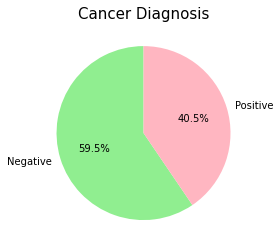

In [6]:
dict_binary = {'0': 'Negative', '1':'Positive'}
labels = [dict_binary[str(lb)] for lb in data.label.value_counts().index]
plt.pie(data.label.value_counts(), labels= labels, startangle=90, autopct='%1.1f%%', colors = ['lightgreen','lightpink']);

plt.gca().set_title('Cancer Diagnosis', fontsize= '15');

print(data['label'].value_counts())

As observed, the majority of the cases (nearly 60%) correspond to healthy patients, whereas cancer was detected in 40% of the cases. We will need to take into account this class imbalance when working with the data. In this way, we will prevent our model from being biased towards the most-represented class.

Let's now visualize some of the histopathologic scans of lymph node sections:

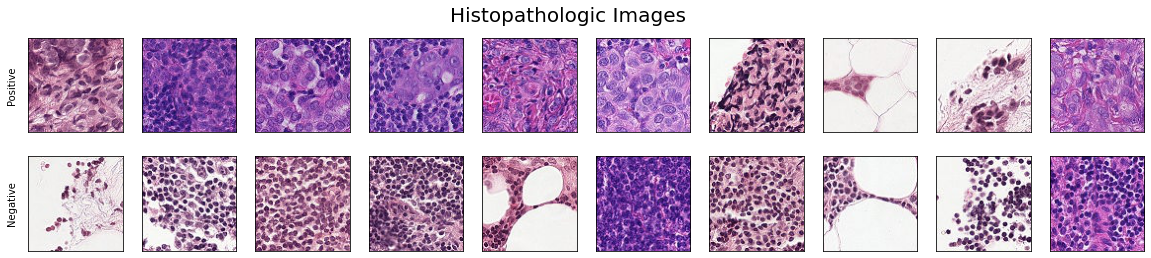

In [7]:
data = shuffle(data)

positive = data[data.label==1]
negative = data[data.label==0]

rand_pos = np.random.choice(positive.id, 10)
rand_neg = np.random.choice(negative.id, 10)

#fig = plt.figure(figsize=(20, 4))

fig, axs = plt.subplots(2, 10,figsize=(20, 4))
fig.suptitle('Histopathologic Images',fontsize=20)

for idx, img in enumerate(np.hstack((rand_pos, rand_neg))):

    ax = plt.subplot(2, 10, idx+1)
    im = Image.open(path_train + '/' + img + '.tif')
    plt.imshow(im)
    
    ax.tick_params(bottom = False, left = False, labelbottom='off') 
    ax.set_xticklabels([])
    ax.set_yticklabels([])

axs[0,0].set_ylabel('Positive')
axs[1,0].set_ylabel('Negative')

plt.tight_layout;

As observed in the figures above, it is really difficult to visually find patterns that clearly characterize each diagnosis due to our limitations. That is the reason why neural networks play an important role for effective disease detection, and have a huge potential for current and future medical applications.

We now create two extra columns; one with the complete name of our image files and another with a more informative description of the diagnosis status.

In [8]:
data['filename'] = data['id'] + '.tif'

In [9]:
data['status'] = data['label'].apply(lambda x: dict_binary[str(x)])

# 2. Data pre-processing <a class="anchor" id="chapter2"></a>

## 2.1. Train, validation and test data  <a class="anchor" id="section_2_1"></a>

We now split our data for training and testing. The former will be used to fit the model whereas the test data will be used to evaluate the model performance. This allows us to know if our model is good at generalization when applied to new unseen images or, on the contrary, it is prone to over-fitting. In this case, the training data will account for 80 % of the initial dataset. Furthermore, we use stratification in order to preserve the same target distribution in both sets.

In [10]:
data_train, data_test = train_test_split(data, test_size=0.2, stratify=data.label, random_state=123)

We further split our training data into training and validation data. The latter will be used by our CNN model as a reference when learning in order to adjust the internal parameters.

In [11]:
data_train, data_valid = train_test_split(data_train, test_size=0.2, stratify=data_train.label, random_state=123)

Let's see how our training and testing data looks like:

0    83781
1    57035
Name: label, dtype: int64


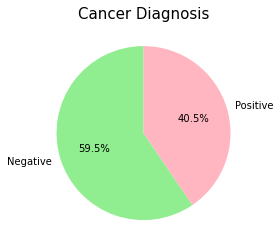

In [12]:
dict_binary = {'0': 'Negative', '1':'Positive'}
labels = [dict_binary[str(lb)] for lb in data_train.label.value_counts().index]
plt.pie(data_train.label.value_counts(), labels= labels, startangle=90, autopct='%1.1f%%', colors = ['lightgreen','lightpink']);

plt.gca().set_title('Cancer Diagnosis', fontsize= '15');

print(data_train['label'].value_counts())

0    20945
1    14259
Name: label, dtype: int64


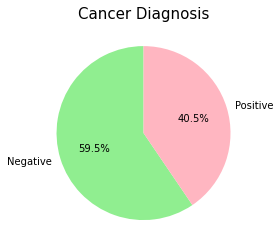

In [13]:
dict_binary = {'0': 'Negative', '1':'Positive'}
labels = [dict_binary[str(lb)] for lb in data_valid.label.value_counts().index]
plt.pie(data_valid.label.value_counts(), labels= labels, startangle=90, autopct='%1.1f%%', colors = ['lightgreen','lightpink']);

plt.gca().set_title('Cancer Diagnosis', fontsize= '15');

print(data_valid['label'].value_counts())

As observed, both sets kept the same class balance.

## 2.2. Data generation <a class="anchor" id="section_2_2"></a>

Next thing to do is to generate additional training data based on the already existing images. To that end, a series of transformations are defined using ImageDataGenerator and applied to the existing images (such as image rotation, flip, zoom, etc.) by means of flow_from_dataframe, and consequently new images are created for training. In this way, the moder will be able to better generalize the results.

Let's first define the image parameters. In this case, we will have images containing 128 x 128 pixels with 3 RGB colour channels. In addition, we set the value of the batch size, which represents the number of samples the model need to run through in order to update the internal parameters.

In [14]:
batch_size = 64
image_size = 128
image_channels = 3
target_size = (image_size, image_size)

We now define the train generator with all the transformations that will be applied to the existing images:

In [15]:
train_datagen = ImageDataGenerator(
    rescale=1. / 255,
    horizontal_flip=True,
    vertical_flip=True,
    zoom_range=0.2, 
    width_shift_range=0.1,
    height_shift_range=0.1
)

In [16]:
train_generator = train_datagen.flow_from_dataframe(
    dataframe = data_train,
    x_col='filename',
    y_col='status',
    directory='./train/',
    target_size=(image_size, image_size),
    batch_size=batch_size,
    shuffle=True,
    class_mode='binary')

Found 140816 validated image filenames belonging to 2 classes.


In the same way, we apply transformations to the validation data. Nonetheless, in this case we only rescale the pixels values as we are not interested in using these data to fit the model. Taking into account that the maximum value of a pixel is 255, we rescale accordingly.

In [17]:
validation_datagen = ImageDataGenerator(rescale=1. / 255)
validation_generator = validation_datagen.flow_from_dataframe(
    dataframe = data_valid,
    x_col='filename',
    y_col='status',
    directory='./train/',
    target_size=(image_size, image_size),
    shuffle=False,
    batch_size=batch_size,
    class_mode='binary')

Found 35204 validated image filenames belonging to 2 classes.


# 3. Convolutional Neural Network (CNN) <a class="anchor" id="chapter3"></a>

## 3.1. ResNet50  <a class="anchor" id="section_3_1"></a>

In [18]:
pretrained_layers = ResNet50(weights='imagenet', include_top = False, input_shape=(image_size, image_size, image_channels))
pretrained_layers.summary()

Metal device set to: Apple M1

systemMemory: 8.00 GB
maxCacheSize: 2.67 GB



2021-11-11 15:21:06.293738: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2021-11-11 15:21:06.294350: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Model: "resnet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 128, 128, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 134, 134, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 64, 64, 64)   9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 64, 64, 64)   256         conv1_conv[0][0]                 
___________________________________________________________________________________________

In [19]:
for layer in pretrained_layers.layers[:143]:
    layer.trainable = False

for layer in pretrained_layers.layers:
    print(layer, layer.trainable)

<keras.engine.input_layer.InputLayer object at 0x281246d90> False
<keras.layers.convolutional.ZeroPadding2D object at 0x282171580> False
<keras.layers.convolutional.Conv2D object at 0x282171910> False
<keras.layers.normalization.batch_normalization.BatchNormalization object at 0x282264a00> False
<keras.layers.core.Activation object at 0x2822642e0> False
<keras.layers.convolutional.ZeroPadding2D object at 0x2821719d0> False
<keras.layers.pooling.MaxPooling2D object at 0x2874d5c70> False
<keras.layers.convolutional.Conv2D object at 0x2874e5b20> False
<keras.layers.normalization.batch_normalization.BatchNormalization object at 0x2874eec10> False
<keras.layers.core.Activation object at 0x2874d5b50> False
<keras.layers.convolutional.Conv2D object at 0x287579130> False
<keras.layers.normalization.batch_normalization.BatchNormalization object at 0x287579640> False
<keras.layers.core.Activation object at 0x287579970> False
<keras.layers.convolutional.Conv2D object at 0x2874d55e0> False
<keras.

## 3.2. Classification head <a class="anchor" id="section_3_2"></a>

In [ ]:
model = Sequential()
model.add(pretrained_layers)

model.add(GlobalAveragePooling2D())
model.add(Dense(512, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))

model.add(Dense(32, activation='relu'))
model.add(BatchNormalization())

model.add(Dense(1))
model.add(Activation('sigmoid'))

## 3.3. Set-up <a class="anchor" id="section_3_3"></a>

In [ ]:
model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['binary_accuracy', 'Precision', 'Recall', 'AUC'])

In [ ]:
callbacks = [EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True, mode='min'),
             ModelCheckpoint(filepath='best_model.h5', monitor='val_loss', save_best_only=True)]

train_step_size = train_generator.n // train_generator.batch_size
validation_step_size = validation_generator.n // validation_generator.batch_size

In [ ]:
class_weights = class_weight.compute_class_weight(class_weight = 'balanced', classes = np.unique(train_generator.classes), y = train_generator.classes) 

In [ ]:
class_weight_dict = dict(enumerate(class_weights))
class_weight_dict

In [ ]:
epochs = 20
history = model.fit(train_generator,   
          validation_data= validation_generator,
          batch_size= batch_size,
          epochs=epochs,
          verbose=1,
          class_weight= class_weight_dict,
          callbacks=callbacks)

$\color{red}{\text{To be continued! This project is still ongoing :) }}$